In [7]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
import splitfolders
import cv2
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras import layers, models
import os
import random
from PIL import Image

In [8]:
# Split the images in the kaggle dataset into 3 different subfolders
input_folder = "/Users/zhoujingchun/Desktop/Faces"
output_folder = "/Users/zhoujingchun/Desktop/DeepfakeRecognition"

split_ratio = (0.8, 0.1, 0.1)

splitfolders.ratio(
    input_folder, 
    output = output_folder,
    seed = 500,
    ratio = split_ratio,
    group_prefix = None
)

Copying files: 2041 files [00:01, 1559.23 files/s]


In [11]:
img_size = (224, 224)
batch_size = 32

train_datagen = ImageDataGenerator(
    preprocessing_function = preprocess_input,
    rotation_range = 20,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode = 'nearest'
)

In [13]:
# Data augmentation (rescale)
test_datagen = ImageDataGenerator(preprocessing_function = preprocess_input)
valid_datagen = ImageDataGenerator(preprocessing_function = preprocess_input)

In [17]:
train_dir = os.path.join(output_folder, 'train')
val_dir = os.path.join(output_folder, 'val')
test_dir = os.path.join(output_folder, 'test')

train_data = train_datagen.flow_from_directory(
    train_dir, 
    target_size = img_size,
    batch_size = batch_size,
    class_mode = 'categorical'
)

valid_data = valid_datagen.flow_from_directory(
    val_dir,
    target_size = img_size,
    batch_size = batch_size,
    class_mode = 'categorical'
)

test_data = test_datagen.flow_from_directory(
    test_dir,
    target_size = img_size,
    batch_size = batch_size,
    class_mode = 'categorical'
)

Found 1632 images belonging to 2 classes.
Found 204 images belonging to 2 classes.
Found 205 images belonging to 2 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


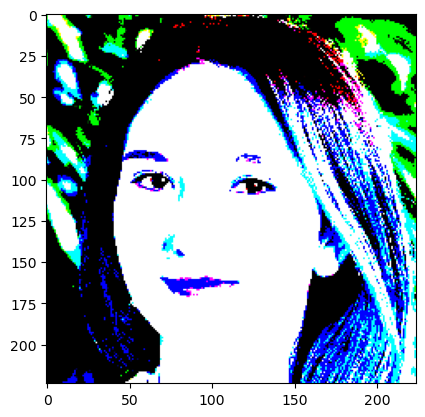

In [19]:
# Print random img
images, labels = next(valid_data)
i = random.randint(0, images.shape[0] - 1)

plt.imshow(images[i])
plt.show()

In [21]:
from keras.applications.resnet import ResNet50
base_model = ResNet50(
    weights = 'imagenet',
    include_top = False,
    input_shape = (img_size[0], img_size[1], 3)
)

base_model.trainable = False

In [23]:
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation = 'relu'),
    layers.Dropout(0.5),
    layers.Dense(2, activation = 'softmax')
])

model.compile(
    optimizer = 'adam',
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

In [25]:
# Training for 250 epochs
model.fit(
    train_data, 
    epochs = 250, 
    validation_data = valid_data
)

/opt/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/250
51/51 ━━━━━━━━━━━━━━━━━━━━ 68s 1s/step - accuracy: 0.5068 - loss: 1.0008 - val_accuracy: 0.5441 - val_loss: 0.6839
Epoch 2/250
51/51 ━━━━━━━━━━━━━━━━━━━━ 67s 1s/step - accuracy: 0.5676 - loss: 0.6790 - val_accuracy: 0.5196 - val_loss: 0.6853
Epoch 3/250
51/51 ━━━━━━━━━━━━━━━━━━━━ 70s 1s/step - accuracy: 0.5906 - loss: 0.6679 - val_accuracy: 0.5441 - val_loss: 0.6751
Epoch 4/250
51/51 ━━━━━━━━━━━━━━━━━━━━ 71s 1s/step - accuracy: 0.5755 - loss: 0.6737 - val_accuracy: 0.5735 - val_loss: 0.6852
Epoch 5/250
51/51 ━━━━━━━━━━━━━━━━━━━━ 71s 1s/step - accuracy: 0.6032 - loss: 0.6521 - val_accuracy: 0.5392 - val_loss: 0.6822
Epoch 6/250
51/51 ━━━━━━━━━━━━━━━━━━━━ 120s 2s/step - accuracy: 0.6086 - loss: 0.6394 - val_accuracy: 0.6275 - val_loss: 0.6505
Epoch 7/250
51/51 ━━━━━━━━━━━━━━━━━━━━ 130s 3s/step - accuracy: 0.6050 - loss: 0.6408 - val_accuracy: 0.5686 - val_loss: 0.6710
Epoch 8/250
51/51 ━━━━━━━━━━━━━━━━━━━━ 117s 2s/step - accuracy: 0.6426 - loss: 0.6297 - val_accuracy: 0.6029 

In [26]:
# Evaluate overall accuracy
test_loss, test_accuracy = model.evaluate(test_data)
print(f'Test Accuracy: {test_accuracy * 100: .2f}%')

7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.6076 - loss: 1.1197
Test Accuracy:  62.44%


In [27]:
class_names = {
    0: 'Fake',
    1: 'Real'
}

In [55]:
def predict_img(image, model):
    test_img = cv2.imread(image)
    test_img = cv2.resize(test_img, (224, 224))
    test_img = np.expand_dims(test_img, axis = 0)
    result = model.predict(test_img)
    r = np.argmax(result)
    if r :
        return 'Yay! This photo is real.'
    return 'Watch out! This photo is a fake!'

def detector(img):
    imgArray = np.array(Image.open(img))
    plt.imshow(imgArray)
    plt.show()
    return predict_img(img, model)

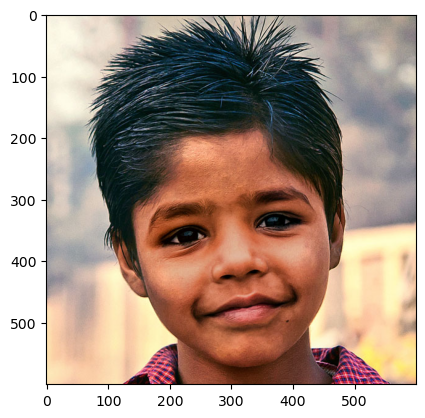

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


'Watch out! This photo is a fake!'

In [45]:
img1 = '/Users/zhoujingchun/Desktop/DeepfakeRecognition/test/fake/mid_364_1111.jpg'
detector(img1)

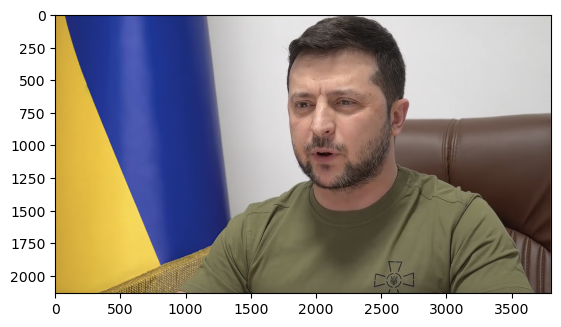

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


'Watch out! This photo is a fake!'

In [59]:
#fake
img2 = '/Users/zhoujingchun/Desktop/zelenskyy.jpg'
detector(img2)

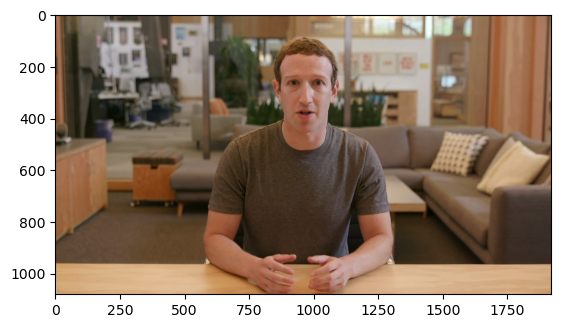

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


'Watch out! This photo is a fake!'

In [61]:
#fake
img3 = '/Users/zhoujingchun/Desktop/zucc.jpg'
detector(img3)

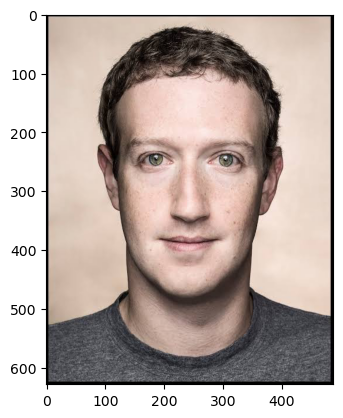

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


'Yay! This photo is real.'

In [93]:
#real
img4 = '/Users/zhoujingchun/Desktop/zuck.jpeg'
detector(img4)

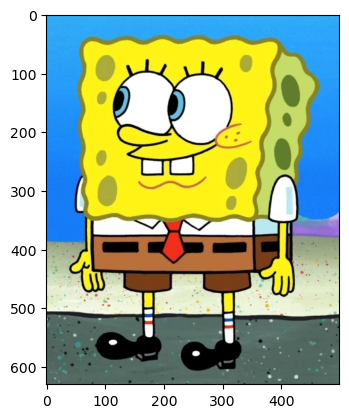

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


'Yay! This photo is real.'

In [65]:
# for fun
img5 = '/Users/zhoujingchun/Desktop/bob.webp'
detector(img5)